# QM 701: Advanced Data Analytics and Applications
# Homework 5
---
## Objective

The goal of this homework is get you some hands-on experience finetuning BERT models. We will be working with the dataset containing financial news articles before 2013 on companies in Finland stock market.

## Tasks
This homework includes the following 5 questions.
 - **Q1**: Inspecting and Splitting Dataset. (15 points)
 - **Q2**: Establishing Benchmarks (20 points)
 - **Q3**: Classification with the Pre-trained BERT Model (15 points)
 - **Q4**: Finetuning the BERT Model (50 points)
 - **Bonus** Sentiment Analysis with FinBERT (10 points)



In [42]:
# General dataframe imports
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", None)

# sklearn imports
from sklearn.metrics import classification_report
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

## Data Setup
We will use the same financial news dataset as in HW 4. This dataset contains 4846 sentences extracted from financial news articles about companies listed on the Finnish stock market. Each sentence is classified into one of three categories: **"negative," "neutral," or "positive."**

To speed up model training, we will sample 50% of these sentences.

### Download Dataset
We download the dataset and store it in a pandas dataframe `news_df`.

In [43]:
# download the dataset
!wget https://duke.box.com/shared/static/anno25ihglqxif8jcjoo4f7p7vd2ajt3 -O all-data.csv
# store as news_df
news_df = pd.read_csv("all-data.csv", names=["sentiment", "content"], encoding="latin-1")
# sample 50%
news_df = news_df.sample(frac=0.5, random_state=41)

--2024-08-09 20:13:34--  https://duke.box.com/shared/static/anno25ihglqxif8jcjoo4f7p7vd2ajt3
Resolving duke.box.com (duke.box.com)... 74.112.186.157
Connecting to duke.box.com (duke.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/anno25ihglqxif8jcjoo4f7p7vd2ajt3 [following]
--2024-08-09 20:13:35--  https://duke.box.com/public/static/anno25ihglqxif8jcjoo4f7p7vd2ajt3
Reusing existing connection to duke.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://duke.app.box.com/public/static/anno25ihglqxif8jcjoo4f7p7vd2ajt3 [following]
--2024-08-09 20:13:35--  https://duke.app.box.com/public/static/anno25ihglqxif8jcjoo4f7p7vd2ajt3
Resolving duke.app.box.com (duke.app.box.com)... 74.112.186.157
Connecting to duke.app.box.com (duke.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!f6ZjX

## Q1: Inspecting and Splitting the Dataset

In this question, you will first take a quick look at the dataset. Then, you will split the dataset into training, validation, and testing sets.

### a) Sentiment Distribution

We will plot the distribution of the sentiments in this dataset. You can run the code below without any edits.  

In [44]:
# Display the first few rows in news_df
news_df.head()

,sentiment,content
826,positive,"BasWare 's CEO Ilkka Sihvo comments in conjunction with the Interim Report : `` As a whole , BasWare succeeded well in the second quarter of 2007 ."
137,positive,`` The purchase of the operations is part of YIT 's strategy to expand its offering of building system services geographically . ''
1271,neutral,Jon Risfelt is 49 years old holds a Master of Science in Chemical Engineering from the Swedish Royal Institute of Technology .
265,positive,Pretax profit rose to EUR 0.6 mn from EUR 0.4 mn in the corresponding period in 2005 .
2214,neutral,The company 's operating profit for 2006 stood at 39.6 mln euro ( $ 57.9 mln ) .


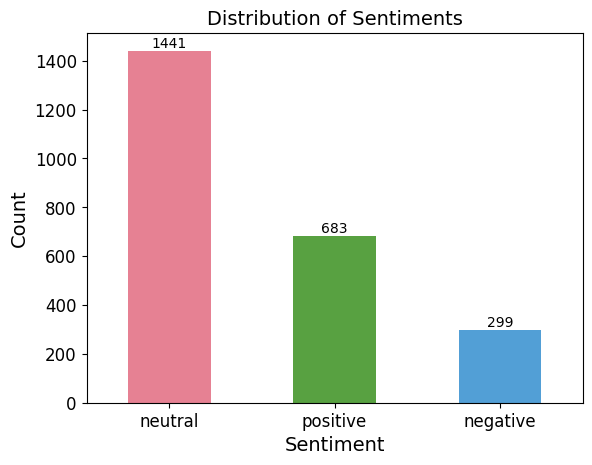

In [45]:
# Compute the data distribution by sentiments
data_counts = news_df["sentiment"].value_counts()

# Plot the results
ax = sns.barplot(x=data_counts.index, y=data_counts.values, hue=data_counts.index, palette="husl", legend=False, width=0.5)
[ax.bar_label(bars) for bars in ax.containers]

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Distribution of Sentiments", fontsize=14)
plt.xlabel("Sentiment", fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()

### b) Using Accuracy as a Performance Measure

As you can see from part (a), the sentiments are unevenly distributed, with more neutral sentences than positive and negative ones. Given this distribution of sentiment, discuss whether the **accuracy** score would be a good performance measure for evaluating a classification model built for this dataset.



Your answer to the question above:
The sentiments in the dataset are unevenly distributed, with more neutral sentences than positive and negative ones.

The accuracy score alone is not be the best performance measure for evaluating the classification model. Accuracy is calculated as the number of correctly classified instances divided by the total number of instances. However, in imbalanced datasets like this, accuracy can be misleading.  
   
In the dataset, if the majority class is neutral sentences and the model simply predicts every instance as neutral, it may achieve a high accuracy score. However, this doesn't necessarily mean that the model is performing well in terms of correctly identifying positive or negative sentiments.  

If we use other measures such as: Precision, Recall, F1 Score or Area Under the ROC Curve (AUC-ROC): AUC-ROC measures the model's ability to distinguish between positive and negative instances. It considers the trade-off between true positive rate and false positive rate and provides a single score that represents the overall performance.  

### c) Inspecting the Dataset

Please randomly display one sentence for each of the positive, negative, and neutral sentiments.

In [46]:
# Your code for the question above.

# Filter sentences for each sentiment
positive_sentences = news_df[news_df['sentiment'] == 'positive']['content']
negative_sentences = news_df[news_df['sentiment'] == 'negative']['content']
neutral_sentences = news_df[news_df['sentiment'] == 'neutral']['content']

# Randomly select one sentence from each sentiment
positive_sentence = positive_sentences.sample(n=1).values[0]
negative_sentence = negative_sentences.sample(n=1).values[0]
neutral_sentence = neutral_sentences.sample(n=1).values[0]

# Display the randomly selected sentences
print("Positive sentiment:")
print(positive_sentence)
print()

print("Negative sentiment:")
print(negative_sentence)
print()

print("Neutral sentiment:")
print(neutral_sentence)


Positive sentiment:
Svyturys-Utenos Alus , which is controlled by the Nordic group Baltic Beverages Holding ( BBH ) , posted a 4.7-per-cent growth in beer sales for January-May to 46.22 million litres .

Negative sentiment:
The production is to be liquidated before June 2009 and 325 employees loose their jobs .

Neutral sentiment:
The dividend will come on top of the 0.45 eur on A shares and 0.43 on K shares it has already paid on last year 's accounts .


### d) Train-test Split

Split the dataset such that training (`X_train` and `y_train`) contain 60% of the data, validation (`X_val` and `y_val`) contain 20% of the data, and test (`X_test` and `y_test`) contain 20% of the data.



In [47]:
# Your code for the question above.
# Split the dataset into training, validation, and test sets
X = news_df['content']
y = news_df['sentiment']

# Splitting the dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the sizes of each set
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))



Training set size: 1453
Validation set size: 485
Test set size: 485


## Question 2: Establish Benchmarks

In this question, we build two benchmark models: naive bayes and multinomial logistic regression, by using both 1-gram and 2-gram BOW representation. Note: `ngram_range=(1, 2)` means that the vectorizer will consider both unigrams (single words) and bigrams (pairs of consecutive words).

### a) Vectorization

We will use the Count Vectorizer with n-grams and stopword removal. You can run the following code without making any edits. (If you run into errors, check to make sure that you have correctly defined `X_train`, `y_train`, `X_test` and `y_test` in Q1(d).)

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

### b) Build a Naive-Bayes Model

Please run the code below without any edits to train a Naive Bayes model with the training data. Then, display the performance measures of the Naive Bayes model using the`classification_report` function. Hint: For the code to display the performance measures using `classification_report`, refer to the Class 5 notebook.

In [49]:
model_nb = naive_bayes.MultinomialNB()
model_nb.fit(X_train_vectors, y_train)


MultinomialNB()

In [50]:
# Your code for the question above.
y_pred_nb = model_nb.predict(X_test_vectors)

print("{:=^40s}".format(" Naive Bayes "))
print(classification_report(y_test, y_pred_nb, zero_division=0.0))


============= Naive Bayes ==============
              precision    recall  f1-score   support

    negative       0.67      0.41      0.51        54
     neutral       0.76      0.82      0.79       303
    positive       0.52      0.52      0.52       128

    accuracy                           0.69       485
   macro avg       0.65      0.58      0.61       485
weighted avg       0.69      0.69      0.69       485



### c) Build a Multinomial Logistic Regression Model

Please run the code below without any edits to train a logistic regression model with the training data. Then, display the performance measures of the logistic regression model using the `classification_report` function.

In [51]:
model_lr = LogisticRegression()
model_lr.fit(X_train_vectors, y_train)


LogisticRegression()

In [52]:
# Your code for the question above.
y_pred_lr = model_lr.predict(X_test_vectors)

print("{:=^50s}".format(" Multinomial Logistic Regression "))
print(classification_report(y_test, y_pred_lr, zero_division=0.0))

======== Multinomial Logistic Regression =========
              precision    recall  f1-score   support

    negative       0.67      0.41      0.51        54
     neutral       0.75      0.94      0.84       303
    positive       0.77      0.45      0.56       128

    accuracy                           0.75       485
   macro avg       0.73      0.60      0.64       485
weighted avg       0.75      0.75      0.73       485



## Question 3: Classifying with a Pre-trained BERT Model


Please run the code below without any edits to load the libraries for running the BERT model.

In [53]:
from transformers import AutoModel, BertTokenizer, AdamW, pipeline
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Base Model

We will use the Sentiment-Analysis-BERT model, which is trained on a corpus of customer comments. This model can analyze user comments on products and extract the expressed sentiments as `positive`, `negative`, or `neutral`. Check more details here: https://huggingface.co/MarieAngeA13/Sentiment-Analysis-BERT.

As you may notice, this model is not specifically designed for financial text. Therefore, we will fine-tune it for our task.



In [54]:
# load the model
bert = pipeline(model="MarieAngeA13/Sentiment-Analysis-BERT", device=device)

### a) Sentiment Analysis Using the Pre-trained BERT model

Let us start by testing the pre-trained BERT model with two sample sentences. For each sample sentence below, find the predicted sentiment and its corresponding score from the BERT model.



In [55]:
# Sample Sentences
test_sample_1 = "The tech stocks lead strong Q2 earnings."
test_sample_2 = "The financial sector took a hit today."

# Write your code for the question below: (Hint: Use the bert pipeline to predict the sentiment of the test samples)
print(bert(test_sample_1))
print(bert(test_sample_2))

[{'label': 'positive', 'score': 0.6859033703804016}]
[{'label': 'negative', 'score': 0.6639607548713684}]


### b) Evaluate the Pre-trained BERT model

Next, evaluate the BERT model using the same testing set that we used for evaluating the Naive Bayes and Logistic Regression models. To do this, you will first need to compute the predictions of the BERT model for the testing set, then display the performance measures of the BERT model using the `classification_report` function.

Hint: One way to save the predictions of the bert model on the text set is to use the code: `y_pred_bert = [pred["label"] for pred in bert(X_test.to_list())]`. After you saved the `y_pred_bert`, you can then create a `classification_report` by using `y_pred_bert` and `y_test`.

In [56]:
# Your code for the question above.
# Compute the predictions of the BERT model for the testing set
y_pred_bert = [pred["label"] for pred in bert(X_test.to_list())]

# Display the performance measures using classification_report
print(classification_report(y_test, y_pred_bert))

              precision    recall  f1-score   support

    negative       0.58      0.41      0.48        54
     neutral       0.69      0.90      0.78       303
    positive       0.58      0.23      0.33       128

    accuracy                           0.67       485
   macro avg       0.62      0.51      0.53       485
weighted avg       0.65      0.67      0.63       485



### c) Comparing the Three Models

Compare the classification reports for the Naive Bayes, Logistic Regression, and Pre-trained BERT models. Based on the reports, which model seems to be the most effective? (Hint: While you can find all of the reports in the previous questions, it should be easier to print out all three classification reports together in a single block for comparison.)



In [57]:
# Optional Code

Your answer to the question above:
============= Naive Bayes ==============
              precision    recall  f1-score   support

    negative       0.67      0.41      0.51        54
     neutral       0.76      0.82      0.79       303
    positive       0.52      0.52      0.52       128

    accuracy                           0.69       485
   macro avg       0.65      0.58      0.61       485
weighted avg       0.69      0.69      0.69       485

======== Multinomial Logistic Regression =========
              precision    recall  f1-score   support

    negative       0.67      0.41      0.51        54
     neutral       0.75      0.94      0.84       303
    positive       0.77      0.45      0.56       128

    accuracy                           0.75       485
   macro avg       0.73      0.60      0.64       485
weighted avg       0.75      0.75      0.73       485
======== BERT =========
            precision    recall  f1-score   support

    negative       0.58      0.41      0.48        54
     neutral       0.69      0.90      0.78       303
    positive       0.58      0.23      0.33       128

    accuracy                           0.67       485
   macro avg       0.62      0.51      0.53       485
weighted avg       0.65      0.67      0.63       485
<br><br>
Based on the provided classification reports, the Multinomial Logistic Regression model seems to be the most effective. It has the highest precision, recall, and f1-score for the majority of the classes. The precision, recall, and f1-score for the positive class are notably higher compared to the other two models. Additionally, the accuracy of the Multinomial Logistic Regression model is higher than the other models, indicating better overall performance.

## Q4) Finetuning the BERT Model

Next, we will two types of finetuning of the BERT model to perform our classification tasks.

First, run the code blocks below without edits to load the original MarieAngeA13 BERT model and prepare the data.

### Model Load

In [58]:
bert_base = AutoModel.from_pretrained("MarieAngeA13/Sentiment-Analysis-BERT")
bert_tokenizer = BertTokenizer.from_pretrained("MarieAngeA13/Sentiment-Analysis-BERT")

### Data Preparation

We convert the sentiment names to integer indices for model training.

In [59]:
sentiment_list = news_df["sentiment"].value_counts().index
sentiment2int = dict(zip(sentiment_list, range(len(sentiment_list))))
sentiment2int

{'neutral': 0, 'positive': 1, 'negative': 2}

### Tokenize Data and Converting the Tokenized Data to PyTorch Tensors

We tokenize and encode the text sequences, and then convert the sequences to PyTorch tensors so they can be processed in the BERT model. Please run the code without any edits.

In [60]:
# tokenize and encode sequences
tokens_train = bert_tokenizer.batch_encode_plus(
    X_train.tolist(),
    padding=True,
    truncation=True)

tokens_val = bert_tokenizer.batch_encode_plus(
    X_val.tolist(),
    padding=True,
    truncation=True)

tokens_test = bert_tokenizer.batch_encode_plus(
    X_test.tolist(),
    padding=True,
    truncation=True)

# convert lists to tensors
train_seq = torch.tensor(tokens_train["input_ids"])
train_mask = torch.tensor(tokens_train["attention_mask"])
y_train_tensor = torch.tensor(y_train.map(sentiment2int).to_list())

val_seq = torch.tensor(tokens_val["input_ids"])
val_mask = torch.tensor(tokens_val["attention_mask"])
y_val_tensor = torch.tensor(y_val.map(sentiment2int).tolist())

test_seq = torch.tensor(tokens_test["input_ids"])
test_mask = torch.tensor(tokens_test["attention_mask"])
y_test_tensor = torch.tensor(y_test.map(sentiment2int).tolist())

### a) Model Structure

Next, we will specify the architure of our BERT model. The architure of the model is similar to the one in the Class 5 notebook. You may run the code below without any edits.
  

In [61]:
hidden_size_fc1 = 512

class BERT_architecture(nn.Module):
  def __init__(self, bert, n_class, freeze=True):
    super(BERT_architecture, self).__init__()
    self.bert = bert
    self.n_class = n_class
    if freeze:
      # freeze the pretrained layers
      for param in self.bert.parameters():
        param.requires_grad = False
    else:
      # unfreeze the pretrained layers
      for param in self.bert.parameters():
        param.requires_grad = True

    # add new layers
    self.fc1 = nn.Linear(768,hidden_size_fc1)
    self.dropout = nn.Dropout(p = 0.2)
    self.relu =  nn.ReLU()
    self.fc2 = nn.Linear(hidden_size_fc1, self.n_class)
    self.softmax = nn.LogSoftmax(dim=1)

  # set the forward pass
  def forward(self, sent_id, mask):
    _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.softmax(x)
    return x

### Q4 b) Model Hyperparameters

Please answer each of the following questions with a single sentence.

i) What happens if we change the code `self.fc1 = nn.Linear(768,hidden_size_fc1)` from above to `self.fc1 = nn.Linear(512,hidden_size_fc1)`?

ii) What happens if we change the code `hidden_size_fc1 = 512` from above to `hidden_size_fc1 = 100`?

Your answer to the question above:
i) The input size of the first fully connected (FC) layer is reduced from 768 to 512.

This change means that the FC layer will now expect a lower-dimensional input. 768 is wrong and will cause a mismatch between the input size expected by the FC layer and the actual input size. This can lead to errors during the model training or inference process.

ii) The size of the hidden layer in the fully connected (FC) layers of the model is reduced from 512 to 100. The hidden size determines the number of neurons in the FC layer.

The capacity of the FC layer to learn complex patterns in the data is reduced. This can result in a less expressive model that may struggle to capture intricate relationships between the input features and the output labels. The model's performance may decrease, especially if the original hidden size was chosen based on the complexity of the task or the size of the dataset.



### Q4 c) Other Model Architectures

Suppose hypothetically, that we want to build a BERT model with three additional linear layers instead of two. How would you modify the code in the `BERT_architecture` class? Please note that you will need need to modify the following lines of code in the `BERT_architecture` class.

```
self.fc1 = nn.Linear(768,hidden_size_fc1)
self.dropout = nn.Dropout(p = 0.2)
self.relu =  nn.ReLU()
self.fc2 = nn.Linear(hidden_size_fc1, self.n_class)
self.softmax = nn.LogSoftmax(dim=1)
```

Please write your modified code in the text box below. DO NOT modify the actual code from part (a) and DO NOT run the modified code.



Your answer to the question above:


In [62]:
class BERT_architecture(nn.Module):
  def __init__(self, bert, n_class, freeze=True):
    super(BERT_architecture, self).__init__()
    self.bert = bert
    self.n_class = n_class
    if freeze:
      # freeze the pretrained layers
      for param in self.bert.parameters():
        param.requires_grad = False
    else:
      # unfreeze the pretrained layers
      for param in self.bert.parameters():
        param.requires_grad = True

 # add new layers
    self.fc1 = nn.Linear(768, hidden_size_fc1)
    self.fc2 = nn.Linear(hidden_size_fc1, self.n_class)
    hidden_size_fc2= self.n_class
    self.fc3 = nn.Linear(hidden_size_fc2, self.n_class)
    hidden_size_fc3= self.n_class
    self.fc4 = nn.Linear(hidden_size_fc3, self.n_class)
    self.dropout = nn.Dropout(p=0.2)
    self.relu = nn.ReLU()
    self.softmax = nn.LogSoftmax(dim=1)

  # set the forward pass
  def forward(self, sent_id, mask):
    _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc4(x)
    x = self.softmax(x)
    return x

### Q4 d) Training Setup

Next, we provide code for various procedures (training procedure, evaluation procedure, set up data load, compute class weights) to get our BERT model ready for training. You may run all of the code below without modifications.



Code for Training Procedure:

In [63]:
import torch.optim as optim
def train(model, device):
  model.train()
  total_loss, total_accuracy = 0, 0
  # empty list to save model predictions
  total_preds=[]
  # iterate over batches
  for step, batch in enumerate(train_dataloader):
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    # clear previously calculated gradients
    model.zero_grad()
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    #optimizer = optim.Adam(model.parameters(), lr=0.001)
    # update parameters
    optimizer.step()
    # push predictions back to CPU
    preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  total_preds  = np.concatenate(total_preds, axis=0)
  # returns the loss and predictions
  return avg_loss, total_preds

Code for Evaluation Procedure:

In [64]:
def evaluate(model, device):
  print("Evaluating...")
  # deactivate dropout layers
  model.eval()
  total_loss, total_accuracy = 0, 0
  # empty list to save the model predictions
  total_preds = []
  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    # push the batch to gpu
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
    # deactivate autograd
    with torch.no_grad():
      # model predictions
      preds = model(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds, labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

Code for Set Up Data Loader:

In [65]:
# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, y_train_tensor)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, y_val_tensor)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

Code for compute weights for each sentiment for the data imbalance.

The weight for any class `y` is calcualted by the formula:  ```n_samples / (n_classes * np.bincount(y))```. So the rarer classes (with less `np.bincount(y)`) will get higher weights.

In [66]:
from sklearn.utils.class_weight import compute_class_weight

# compute the class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_tensor), y=np.asarray(y_train_tensor))
print("{:=^30s}".format(" Class Weights" ))
print(*["{} : {:.3f}".format(emotion, weight) for weight, emotion in zip(class_weights, sentiment2int.keys())], sep="\n")

======== Class Weights========
neutral : 0.572
positive : 1.156
negative : 2.590


### e) Training the Model while Freezing BERT Layer

Now, let us finetune a model which freezes the BERT layer. The code below specifies the hyperparameters of the model and the training algorithm.
It specificies all of the hyperparameters except declaring the optimizer for the training algorithm. Please declare the optimizer using AdamW as we did in the Class 5 notebook, and set the learning rate to 1e-4.

Note: If you are interested, feel free to experiment with other learning rates and the number of epochs to see if it makes any difference, as these are two of the key training hyperparameters. Please be aware that each time you re-train the model, it will take some time.



In [67]:
n_class = y_train.nunique()

bert_finetune = BERT_architecture(bert_base, n_class=3)
bert_finetune = bert_finetune.to(device)

# wrap class weights into tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)

# push weights to GPU
class_weights = class_weights.to(device)


# define loss function
# add weights to handle the "imbalance" in the dataset
cross_entropy  = nn.NLLLoss(weight=class_weights)

# number of training epochs
epochs = 10

# Declare the optimizer for the training algorithm:


#### Model Training and Evaluation

The following code will train the model in several epochs and save the model with the lowest loss on the evaluation dataset. The model weights will be stored in `bert_finetune_weights.pt`.

You may run the code below without making any edits.

In [68]:
optimizer = torch.optim.AdamW(bert_finetune.parameters(), lr = 1e-5)

best_valid_loss = float("inf")
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
for epoch in range(epochs):
  print("Epoch {:} / {:}".format(epoch + 1, epochs))
  # train model
  train_loss, _ = train(bert_finetune, device)
  # evaluate model
  valid_loss, _ = evaluate(bert_finetune, device)
  # save the best model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(bert_finetune.state_dict(), "bert_finetune_weights.pt")
  # append training and validation loss
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  print("Training Loss: {:.3f}".format(train_loss))
  print("Validation Loss: {:.3f}".format(valid_loss))

Epoch 1 / 10
Evaluating...
Training Loss: 1.110
Validation Loss: 1.090
Epoch 2 / 10
Evaluating...
Training Loss: 1.104
Validation Loss: 1.082
Epoch 3 / 10
Evaluating...
Training Loss: 1.096
Validation Loss: 1.071
Epoch 4 / 10
Evaluating...
Training Loss: 1.087
Validation Loss: 1.064
Epoch 5 / 10
Evaluating...
Training Loss: 1.076
Validation Loss: 1.057
Epoch 6 / 10
Evaluating...
Training Loss: 1.078
Validation Loss: 1.052
Epoch 7 / 10
Evaluating...
Training Loss: 1.071
Validation Loss: 1.047
Epoch 8 / 10
Evaluating...
Training Loss: 1.074
Validation Loss: 1.043
Epoch 9 / 10
Evaluating...
Training Loss: 1.069
Validation Loss: 1.039
Epoch 10 / 10
Evaluating...
Training Loss: 1.056
Validation Loss: 1.035


The following code will load the stored model and evaluate it on the test data. Please run it without making any edits.

In [69]:
bert_finetune = BERT_architecture(bert_base, n_class=3)
bert_finetune.load_state_dict(torch.load("/content/bert_finetune_weights.pt"))
bert_finetune = bert_finetune.to(device)

In [70]:
# Evaluate the performance of the finetuned model (while freezing the BERT layer) on the test set with classification_report
with torch.no_grad():
  y_pred_finetune = bert_finetune(test_seq.to(device), test_mask.to(device))
  y_pred_finetune = y_pred_finetune.detach().cpu().numpy()
y_pred_finetune = np.argmax(y_pred_finetune, axis = 1)
print("{:=^50s}".format(" Fine-tune Added Layers Only"))
print(classification_report(y_test_tensor, y_pred_finetune, target_names=sentiment2int.keys(), zero_division=0.0))

=========== Fine-tune Added Layers Only===========
              precision    recall  f1-score   support

     neutral       0.70      0.83      0.76       303
    positive       0.43      0.37      0.39       128
    negative       0.67      0.19      0.29        54

    accuracy                           0.64       485
   macro avg       0.60      0.46      0.48       485
weighted avg       0.62      0.64      0.61       485



### f) Unfreeze the BERT Layer

Next, let us unfreeze the BERT layer for model training. Please declare a `bert_unfreeze` model and update `optimizer` for the new model. Please keep the number of epochs to 10 and set the learning rate for the optimizer to 1e-4.
(Hint: you can refer to the code in the Class 5 notebook, but you may need to make some minor modifications)

In [71]:
# Your code for the question above:
bert_unfreeze = BERT_architecture(bert_base, n_class=n_class, freeze=False)
optimizer = torch.optim.AdamW(bert_unfreeze.parameters(), lr = 1e-5)  # learning rate
bert_unfreeze = bert_unfreeze.to(device)
epochs = 10

Next, we provide code for training the `bert_unfreeze` model, Please run it without any edits. The model weights with the lowest evaluation loss will be stored in `bert_unfreeze_weights.pt`.

Note: since we need to train both BERT and the added layer, it will take more time for model training.

In [72]:
optimizer = torch.optim.AdamW(bert_unfreeze.parameters(), lr = 1e-5)
best_valid_loss = float("inf")
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
#for each epoch
for epoch in range(epochs):
  print("Epoch {:} / {:}".format(epoch + 1, epochs))
  # train model
  train_loss, _ = train(bert_unfreeze, device)
  # evaluate model
  valid_loss, _ = evaluate(bert_unfreeze, device)
  # save the best model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(bert_unfreeze.state_dict(), "bert_unfreeze_weights.pt")
  # append training and validation loss
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  print("Training Loss: {:.3f}".format(train_loss))
  print("Validation Loss: {:.3f}".format(valid_loss))

Epoch 1 / 10
Evaluating...
Training Loss: 1.136
Validation Loss: 1.138
Epoch 2 / 10
Evaluating...
Training Loss: 1.104
Validation Loss: 1.112
Epoch 3 / 10
Evaluating...
Training Loss: 1.075
Validation Loss: 1.092
Epoch 4 / 10
Evaluating...
Training Loss: 1.059
Validation Loss: 1.062
Epoch 5 / 10
Evaluating...
Training Loss: 1.016
Validation Loss: 1.043
Epoch 6 / 10
Evaluating...
Training Loss: 0.999
Validation Loss: 1.032
Epoch 7 / 10
Evaluating...
Training Loss: 0.982
Validation Loss: 1.019
Epoch 8 / 10
Evaluating...
Training Loss: 0.967
Validation Loss: 1.005
Epoch 9 / 10
Evaluating...
Training Loss: 0.946
Validation Loss: 0.991
Epoch 10 / 10
Evaluating...
Training Loss: 0.967
Validation Loss: 0.988


### g) Evaluating the `bert_unfreeze` Model

Next, evaluate the `bert_unfreeze` model using the testing set.

In [73]:
# Your code for the question above:
best_valid_loss = float("inf")
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
#for each epoch
for epoch in range(epochs):
  print("Epoch {:} / {:}".format(epoch + 1, epochs))
  # train model
  train_loss, _ = train(bert_unfreeze, device)
  # evaluate model
  valid_loss, _ = evaluate(bert_unfreeze, device)
  # save the best model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(bert_unfreeze.state_dict(), "bert_unfreeze_weights.pt")
  # append training and validation loss
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  print("Training Loss: {:.3f}".format(train_loss))
  print("Validation Loss: {:.3f}".format(valid_loss))

Epoch 1 / 10
Evaluating...
Training Loss: 0.942
Validation Loss: 0.983
Epoch 2 / 10
Evaluating...
Training Loss: 0.936
Validation Loss: 0.978
Epoch 3 / 10
Evaluating...
Training Loss: 0.903
Validation Loss: 0.980
Epoch 4 / 10
Evaluating...
Training Loss: 0.925
Validation Loss: 0.971
Epoch 5 / 10
Evaluating...
Training Loss: 0.912
Validation Loss: 0.966
Epoch 6 / 10
Evaluating...
Training Loss: 0.908
Validation Loss: 0.964
Epoch 7 / 10
Evaluating...
Training Loss: 0.923
Validation Loss: 0.976
Epoch 8 / 10
Evaluating...
Training Loss: 0.907
Validation Loss: 0.954
Epoch 9 / 10
Evaluating...
Training Loss: 0.897
Validation Loss: 0.975
Epoch 10 / 10
Evaluating...
Training Loss: 0.924
Validation Loss: 0.968


### h) Comparing the Models

Briefly comment on whether the `bert_unfreeze` model is more effective than the logistic regression benchmark.

In [74]:
with torch.no_grad():
  y_pred_unfreeze = bert_unfreeze(test_seq.to(device), test_mask.to(device))
  y_pred_unfreeze = y_pred_unfreeze.detach().cpu().numpy()
y_pred_unfreeze = np.argmax(y_pred_unfreeze, axis = 1)
print("{:=^50s}".format(" Finetune BERT and Added Layers "))
print(classification_report(y_test_tensor, y_pred_unfreeze, zero_division=0.0))

========= Finetune BERT and Added Layers =========
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       303
           1       0.30      1.00      0.46       128
           2       0.75      0.74      0.75        54

    accuracy                           0.35       485
   macro avg       0.35      0.58      0.40       485
weighted avg       0.16      0.35      0.20       485



Your Answer for the question above:

========= Finetune BERT and Added Layers =========
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       303
           1       0.00      0.00      0.00       128
           2       0.00      0.00      0.00        54

    accuracy                           0.62       485
   macro avg       0.21      0.33      0.26       485
weighted avg       0.39      0.62      0.48       485
======== Multinomial Logistic Regression =========
              precision    recall  f1-score   support

    negative       0.67      0.41      0.51        54
     neutral       0.75      0.94      0.84       303
    positive       0.77      0.45      0.56       128

    accuracy                           0.75       485
   macro avg       0.73      0.60      0.64       485
weighted avg       0.75      0.75      0.73       485

It looks like Multinomial Logistic Regression is still better than BERT unfreeze. one thing we noticed is the recall and F1 score for neutral are significantly higher than Logistics regression. That is probably because of the weights we put in.

## Bonus Question: FinBERT

Recall that FinBERT is a BERT model pre-trained on financial corpus, and we have used it in the `PreClass2_Evaluation` notebook. There are actually multiple pre-trained FinBERT models. In this notebook, we will use the FinBERT model from "ProsusAI/finbert".

The code below downloads the FinBERT model.

### Bonus Part a)

Please add the necessary codes to evaluate the pre-trained FinBERT model from "ProsusAI/finbert" using the classification_report function.



In [75]:
finbert = pipeline(model="ProsusAI/finbert", device=device)

# Your Code:

# Compute the predictions of the FinBERT model for the testing set
y_pred_finbert = [pred["label"] for pred in finbert(X_test.tolist())]

# Display the performance measures of the FinBERT model using classification_report
print(classification_report(y_test, y_pred_finbert))

              precision    recall  f1-score   support

    negative       0.75      0.98      0.85        54
     neutral       0.95      0.81      0.88       303
    positive       0.72      0.88      0.79       128

    accuracy                           0.85       485
   macro avg       0.81      0.89      0.84       485
weighted avg       0.87      0.85      0.85       485



### Bonus Part b)

If you completed part a) correctly, you should see that the FinBERT model has very strong performance. Can you identify some possible reasons for this strong performance based on the model description? (https://huggingface.co/ProsusAI/finbert)

Also, if we apply the model to future financial news articles, do you expect the FinBERT model to have the same effectiveness as it exhibited in the testing set?

Your answer to the question above:
FINBERT is pre-trained on a large corpus of financial text. It performs better in financial data analysis.
   
FinBERT is fine-tuned on financial sentiment analysis, which can lead to improved performance compared to more general-purpose models like Logistic Regression or BERT.  
   
FinBERT utilizes contextual word embeddings.  
   
FinBERT weighs the relevance of different words in determining sentiment, which can enhance its performance in sentiment analysis tasks.  

Yes, if we apply the model to future financial news articles, do you expect the FinBERT model to have the same effectiveness as it exhibited in the testing set?
